In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from scipy.sparse import *
# import enchant
from gensim.parsing.preprocessing import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib notebook

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## RegExp crash course

https://regex101.com

https://regexr.com

In [3]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [4]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [5]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [6]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [7]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [8]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [9]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [10]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [11]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [12]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [13]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [14]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

# Обработка реального текста

In [15]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [16]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

[**Data**](http://study.mokoron.com/)

---

In [17]:
DATA_PATH = 'corpus.csv'

In [18]:
df = pd.read_csv(DATA_PATH,index_col=0)#, header=None, sep=';',
#                  names=['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 
#                         'tfol', 'tfrien', 'listcount'])
print(df.shape)

(216, 4)


In [19]:
df.head()

,auto,crime,culture,education
0,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
1,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><strong><em>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
2,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."
3,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p style=""text-..."
4,"[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>...","[<div class=""itemFullText"">\r\n<p><em><strong>..."


In [20]:
df.dtypes

auto         object
crime        object
culture      object
education    object
dtype: object

---

In [33]:
# corpus, texts = [], []

# for topic in log_progress(df.as_matrix()):
#     for message in topic:
#         sp = message.split('\n')
#         corpus += sp
#         texts += sp
# #     break

# print(len(corpus), len(texts))
# del corpus, texts

In [21]:
corpus = []
for topic in df:
    corpus += df[topic].tolist()
    
corpus = pd.Series(corpus)
corpus = corpus.apply(lambda x: x.lower())
corpus = corpus.apply(strip_tags)
corpus = corpus.apply(strip_punctuation2)
corpus = corpus.apply(strip_numeric)
corpus = corpus.apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', x))
corpus = corpus.apply(lambda x: re.sub('«|»', ' ', x))
corpus = corpus.apply(strip_multiple_whitespaces)
corpus = corpus.apply(lambda x: x.partition(' – ')[2])
# corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus.iloc[-1]

'сегодня в городе тольна соберутся победителей ii международного творческого детского фотоконкурса в объятиях природы организаторами масштабного проекта выступают фонд содействия развитию муниципальных образований ассоциация территорий расположения атомных электростанций ао концерн росэнергоатом и венгерская аэс пакш город полярные зори представят виктория серебренникова и екатерина таранникова в течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по москве с визитом в экспозиционный центр концерна росэнергоатом и будапеште в тольна российские школьники посетят серию мастер классов от известного профессионального фотохудожника балинта винце берег реки дунай маковые поля рыболовные пруды венгерские деревушки и аэс пакш список мест проведения уроков фотоискусства запланированы и съемки метеоритного дождя итогом экологического лагеря станут не только прекрасные фотографии новые знания приятные впечатления но и дружеские связи между шк

In [22]:
print(len(corpus))
corpus.iloc[-1]

864


'сегодня в городе тольна соберутся победителей ii международного творческого детского фотоконкурса в объятиях природы организаторами масштабного проекта выступают фонд содействия развитию муниципальных образований ассоциация территорий расположения атомных электростанций ао концерн росэнергоатом и венгерская аэс пакш город полярные зори представят виктория серебренникова и екатерина таранникова в течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по москве с визитом в экспозиционный центр концерна росэнергоатом и будапеште в тольна российские школьники посетят серию мастер классов от известного профессионального фотохудожника балинта винце берег реки дунай маковые поля рыболовные пруды венгерские деревушки и аэс пакш список мест проведения уроков фотоискусства запланированы и съемки метеоритного дождя итогом экологического лагеря станут не только прекрасные фотографии новые знания приятные впечатления но и дружеские связи между шк

**Уберем ссылки:**

In [23]:
print(len(corpus))

864


**Уберем лишние пробелы:**

In [86]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

864


In [76]:
corpus[-1]

'[\rВЕНГРИЯ/ 7 августа/ БИ-ПОРТ – Сегодня в городе Тольна соберутся 25 победителей II Международного творческого детского фотоконкурса «В объятиях природы». Организаторами масштабного проекта выступают Фонд содействия развитию муниципальных образований «Ассоциация территорий расположения атомных электростанций», АО «Концерн Росэнергоатом» и венгерская АЭС «Пакш».\rГород Полярные Зори представят Виктория Серебренникова и Екатерина Таранникова. В течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по Москве с визитом в экспозиционный центр Концерна «Росэнергоатом» и Будапеште. В Тольна российские школьники посетят серию мастер-классов от известного профессионального фотохудожника Балинта Винце.\rБерег реки Дунай, маковые поля, рыболовные пруды, венгерские деревушки и АЭС «Пакш» - список мест проведения уроков фотоискусства. Запланированы и съемки метеоритного дождя.\rИтогом экологического лагеря станут не только прекрасные фотографии

**Уберем другие лишние символы:**

In [45]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [47]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

864


In [48]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

864


In [49]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

864


In [50]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

864


In [51]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

864


In [52]:
corpus[-1]

'div classitemFullText\rpemstrongВЕНГРИЯ августа БИПОРТstrong em– Сегодня в городе Тольна соберутся победителей II Международного творческого детского фотоконкурса В объятиях природы Организаторами масштабного проекта выступают Фонд содействия развитию муниципальных образований Ассоциация территорий расположения атомных электростанций АО Концерн Росэнергоатом и венгерская АЭС Пакш p\rpГород Полярные Зори представят Виктория Серебренникова и Екатерина Таранникова В течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по Москве с визитом в экспозиционный центр Концерна Росэнергоатом и Будапеште В Тольна российские школьники посетят серию мастерклассов от известного профессионального фотохудожника Балинта Винцеp\rpБерег реки Дунай маковые поля рыболовные пруды венгерские деревушки и АЭС Пакш список мест проведения уроков фотоискусства Запланированы и съемки метеоритного дождяp\rpИтогом экологического лагеря станут не только прекрасные 

In [54]:
# texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
# print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

864


In [55]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

864


In [56]:
corpus[-1]

'div classitemfulltext\rpemstrongвенгрия августа бипортstrong em– сегодня в городе тольна соберутся победителей ii международного творческого детского фотоконкурса в объятиях природы организаторами масштабного проекта выступают фонд содействия развитию муниципальных образований ассоциация территорий расположения атомных электростанций ао концерн росэнергоатом и венгерская аэс пакш p\rpгород полярные зори представят виктория серебренникова и екатерина таранникова в течение десяти дней в рамках работы экологического лагеря ребят ждёт увлекательная экскурсионная программа по москве с визитом в экспозиционный центр концерна росэнергоатом и будапеште в тольна российские школьники посетят серию мастерклассов от известного профессионального фотохудожника балинта винцеp\rpберег реки дунай маковые поля рыболовные пруды венгерские деревушки и аэс пакш список мест проведения уроков фотоискусства запланированы и съемки метеоритного дождяp\rpитогом экологического лагеря станут не только прекрасные 

In [57]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

864


In [58]:
corpus[100]

'div classitemfulltext\rpemstrongзеленоборский ноября бипорт strongem нетрезвый житель зеленоборского устроил кучу проблем местным пожарным на своем автомобиле он влетел в здание пожарной части по информации очевидцев в социальных сетях авария произошла около утра на место дтп приехали экстренные службыp\rp экипаж спасателей прибыл первым на место происшествия комментируют пользователи социальных сетейp div'

In [25]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [26]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(corpus[:]):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens))#, len(texts))

598


In [ ]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

In [ ]:
dict_ru = enchant.Dict("ru_RU")

In [ ]:
corpus_tokens_ench = []
inds_to_drop = []

for i, tokens in enumerate(log_progress(corpus_tokens)):
    tmp_tokens = []
    for word in tokens:
        if dict_ru.check(word):
            tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens_ench.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
        
print(len(corpus_tokens_ench))#, len(texts))

In [27]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [28]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

VBox(children=(HTML(value=''), IntProgress(value=0, max=598)))

598


In [29]:
corpus_tokens[100]

['дороге',
 'колой',
 'туломой',
 'народного',
 'единства',
 'улетела',
 'кювет',
 'иномарка',
 'свидетели',
 'происшествия',
 'сняли',
 'выложили',
 'социальные',
 'сети',
 'видео',
 'котором',
 'пытаются',
 'достать',
 'автомобиль',
 'получается',
 'трудом',
 'машина',
 'лежит',
 'достаточно',
 'дороги',
 'приходится',
 'использовать',
 'стрелу',
 'буквально',
 'толкать',
 'автомобиль',
 'своими',
 'плечами',
 'видео',
 'ссылке']

In [30]:
corpus_tokens_stem[100]

['дорог',
 'кол',
 'тулом',
 'народн',
 'единств',
 'улетел',
 'кювет',
 'иномарк',
 'свидетел',
 'происшеств',
 'снял',
 'вылож',
 'социальн',
 'сет',
 'виде',
 'котор',
 'пыта',
 'доста',
 'автомобил',
 'получа',
 'труд',
 'машин',
 'леж',
 'достаточн',
 'дорог',
 'приход',
 'использова',
 'стрел',
 'буквальн',
 'толка',
 'автомобил',
 'сво',
 'плеч',
 'виде',
 'ссылк']

---

In [31]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
# texts = np.asarray(texts)

print(len(corpus_tokens_stem))#, len(texts))

598


In [32]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

598


(0, 30)

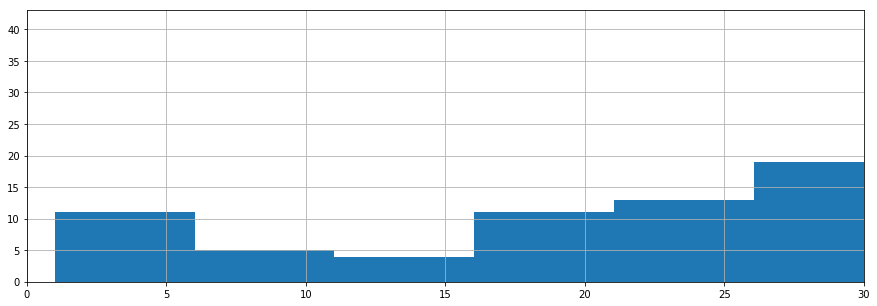

In [33]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [34]:
corpus_tokens_stem[diffs == 2]

array([list(['вход', 'свободн'])], dtype=object)

In [35]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.9966555183946488

In [37]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(corpus[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

VBox(children=(HTML(value=''), IntProgress(value=0, max=598)))

596 596


In [40]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
# texts = np.asarray(corpus)

print(len(corpus_tokens_stem))#, len(texts))

596


In [41]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

596


(0, 10)

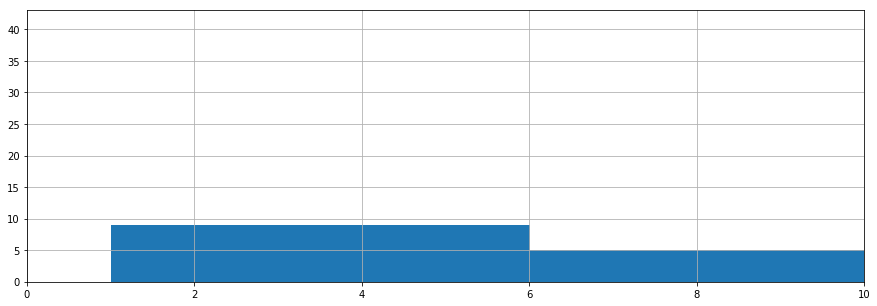

In [42]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [43]:
corpus_tokens_stem[diffs == 7]

array([ list(['будьт', 'предельн', 'внимательн', 'общен', 'телефон', 'незнаком', 'людьм'])], dtype=object)

In [44]:
corpus_tokens_stem[diffs >= 8].shape

(586,)

In [46]:
corp4learning = corpus_tokens_stem[diffs >= 8]
# texts4learning = texts[diffs >= 8]

In [47]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [124]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

7028


In [125]:
real_vocab = dict.fromkeys(vocab,0)
for text in corp4learning:
    for word in text:
        real_vocab[word]+=1
serialised_vocab = pd.Series(real_vocab)
serialised_vocab.sort_values(ascending=False,inplace=True)
serialised_vocab.head()

мурманск     694
област       268
автомобил    196
работ        182
дел          168
dtype: int64

In [126]:
top100 = serialised_vocab.head(100).values

<IPython.core.display.Javascript object>


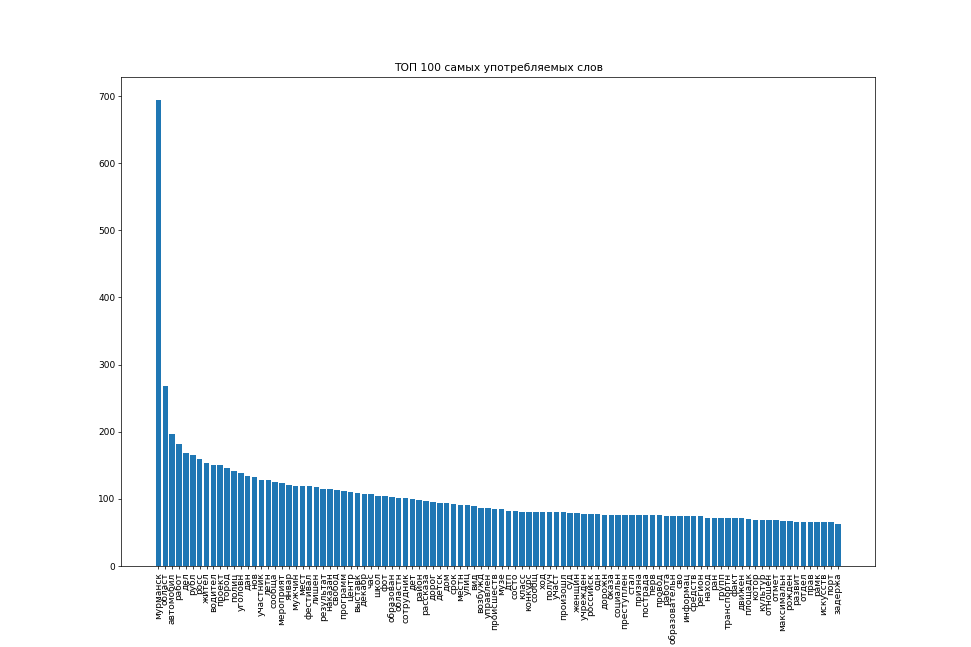

In [127]:
plt.figure(figsize=(15,10))
plt.bar(serialised_vocab.head(100).index,serialised_vocab.head(100).values)
plt.title('ТОП 100 самых употребляемых слов')
plt.xticks(rotation='vertical');

### Удалим самые употребляемые

In [128]:
vocab.pop(vocab.index('мурманск'))

'мурманск'

In [129]:
vocab.pop(vocab.index('област'))

'област'

In [92]:
'мурманск' in vocab

False

In [93]:
serialised_vocab = pd.Series(vocab)

In [130]:
serialised_vocab.pop(item='мурманск')
serialised_vocab.pop(item='област')

268

In [110]:
corp_matrix = []
for text  in corp4learning:
    text_list = []
    for word in text:
        if word in serialised_vocab.values:
            text_list.append(serialised_vocab[serialised_vocab == word].index.values[0]) 
    corp_matrix.append(text_list)

In [111]:
corp_matrix

[[2241,
  4899,
  5105,
  3905,
  6400,
  6835,
  4849,
  1363,
  6219,
  4855,
  5971,
  2498,
  439,
  4502,
  1971,
  1988,
  2717,
  1533,
  1181,
  3830,
  5834,
  4994,
  1366,
  34,
  2937,
  2758,
  5009,
  5811,
  5589,
  4331],
 [4849,
  1363,
  6219,
  4855,
  6498,
  3979,
  643,
  5406,
  2634,
  3980,
  3938,
  5769,
  5203,
  1003,
  2985,
  4848,
  7011,
  5105,
  1345,
  4899,
  2162,
  643,
  34,
  1158,
  5976,
  6400,
  1780,
  5976,
  4899,
  2241,
  1358,
  2985,
  2546,
  4167,
  3938,
  4821,
  6754,
  3215,
  3980,
  3938,
  5226,
  1408,
  4420,
  3384,
  112,
  6628,
  1408],
 [6220,
  2219,
  4849,
  1363,
  6219,
  4855,
  6498,
  6240,
  2717,
  5769,
  5322,
  4855,
  5632,
  7011,
  6752,
  5105,
  2148,
  6551,
  1361,
  643,
  6290,
  4288,
  4358,
  1856,
  5970,
  773,
  5978,
  34,
  1358,
  853,
  818,
  4282,
  1361,
  5971,
  34,
  5970,
  33,
  1358,
  6059,
  2507,
  2491,
  6682,
  1161,
  5226,
  1408,
  2546,
  643,
  3384,
  112,
  6628,
  

In [115]:
serialised_vocab[serialised_vocab == 'кольск'].index.values[0]

2241

In [120]:
serialised_vocab.loc[2241]

'кольск'

In [169]:
serialised_vocab.index.values

array(['автомобил', 'работ', 'дел', ..., 'узл', 'несет', 'ященк'], dtype=object)

In [174]:
text

'на кольском проспекте в районе перекрёстка на улице шевченко произошло дорожно транспортное происшествие столкнулись лада и ваз по предварительной информации в одной из искорёженных машин заблокирована девушка пассажир спасатели пытаются её достать из автомобиля кроме мчс на месте работают сотрудники скорой помощи и дпс '

In [177]:
text = corp4learning[0]
def computeTF(text):
    text_dict = set()
    for word in text:
        if word in serialised_vocab.index.values:
            text_dict.add(word)
    text_len = len(text)
    print(text_dict)
    text_dict = dict.fromkeys(text_dict,0)
    for word in text:
        if word in text_dict.keys():
            text_dict[word] += 1
    tf_vec = []
    for word in text_dict.keys():
        tf_vec.append(text_dict[word]/text_len)
    return tf_vec

In [178]:
computeTF(text)

{'мест', 'происшеств', 'скор', 'улиц', 'доста', 'дорожн', 'ваз', 'пассажир', 'столкнул', 'произошл', 'шевченк', 'сотрудник', 'район', 'заблокирова', 'автомобил', 'пыта', 'информац', 'спасател', 'транспортн', 'девушк', 'лад', 'проспект', 'кольск', 'машин', 'работа', 'перекрестк', 'мчс', 'предварительн', 'искорежен', 'помощ'}


[0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333,
 0.03333333333333333]

In [179]:
def computeIDF(corpus,text):
    idf_vec = []
    for word in text:
        if word in serialised_vocab.index.values:
            idf_vec.append(len(corpus)/serialised_vocab[word])
    return np.log(idf_vec)

In [180]:
def computeTF_IDF(corpus,text):
    return computeTF(text)*computeIDF(corpus,text)

In [181]:
computeIDF(corp4learning,text)

array([ 2.52317219,  3.80837043,  1.78835231,  4.29387825,  1.86246028,
        6.37331979,  1.99129315,  2.04258645,  2.11063991,  1.93066853,
        2.78980085,  4.98702543,  2.87681223,  2.70975814,  2.0692547 ,
        6.37331979,  2.44149416,  6.37331979,  3.28227734,  3.60073107,
        4.29387825,  3.80837043,  4.29387825,  1.09520513,  3.73426246,
        1.5941963 ,  2.05583168,  1.75819927,  3.54010645,  2.78980085])

In [182]:
computeTF_IDF(corp4learning,text)

{'мест', 'происшеств', 'скор', 'улиц', 'доста', 'дорожн', 'ваз', 'пассажир', 'столкнул', 'произошл', 'шевченк', 'сотрудник', 'район', 'заблокирова', 'автомобил', 'пыта', 'информац', 'спасател', 'транспортн', 'девушк', 'лад', 'проспект', 'кольск', 'машин', 'работа', 'перекрестк', 'мчс', 'предварительн', 'искорежен', 'помощ'}


array([ 0.08410574,  0.12694568,  0.05961174,  0.14312927,  0.06208201,
        0.21244399,  0.06637644,  0.06808621,  0.07035466,  0.06435562,
        0.09299336,  0.16623418,  0.09589374,  0.09032527,  0.06897516,
        0.21244399,  0.08138314,  0.21244399,  0.10940924,  0.12002437,
        0.14312927,  0.12694568,  0.14312927,  0.03650684,  0.12447542,
        0.05313988,  0.06852772,  0.05860664,  0.11800355,  0.09299336])